# CRISPR gRNA On-Target Efficiency Prediction
## Complete Machine Learning Pipeline

**Team:** Dedeepya Chaalika Chukka (1002231599), Puli Joshith Reddy (1002231617), Mokshagna (1002198292)

This notebook contains the complete pipeline from data ingestion to model training and evaluation.

## 1. Import Libraries

In [27]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import joblib


## 2. Data Download and Generation

In [5]:
def download_doench_data():
    print("Downloading Doench 2016 CRISPR dataset...")
    urls = [
        "https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3437-S4.xlsx",
        "https://raw.githubusercontent.com/RTH-tools/crispron/master/crispron.csv",
    ]
    for i, url in enumerate(urls):
        try:
            print(f"Trying source {i+1}...")
            if url.endswith('.xlsx'):
                data = pd.read_excel(url)
            else:
                response = requests.get(url, timeout=30)
                response.raise_for_status()
                data = pd.read_csv(StringIO(response.text))
            print(f"Downloaded {len(data)} gRNA sequences from source {i+1}")
            return data, i+1
        except Exception as e:
            print(f"  Failed: {e}")
            continue
    print("All sources failed. Creating synthetic dataset...")
    return create_synthetic_dataset(), 0

def create_synthetic_dataset():
    print("Generating synthetic CRISPR dataset...")
    np.random.seed(42)
    n_samples = 5000
    sequences = []
    scores = []
    bases = ['A', 'C', 'G', 'T']
    
    for i in range(n_samples):
        seq = ''.join(np.random.choice(bases, 30))
        gc_content = (seq.count('G') + seq.count('C')) / 30
        guide = seq[4:24]
        pos_effect = 1.0 if guide[0] == 'G' else 0.8
        base_score = (gc_content * 0.6 + pos_effect * 0.4) * 100
        noise = np.random.normal(0, 10)
        score = np.clip(base_score + noise, 0, 100)
        sequences.append(seq)
        scores.append(score)
    
    data = pd.DataFrame({
        '30mer': sequences,
        'efficiency_score': scores
    })
    print(f"Generated {len(data)} synthetic gRNA sequences")
    return data

raw_data, source_id = download_doench_data()
print(f"\nDataset shape: {raw_data.shape}")
raw_data.head()

Trying source 1...
  Failed: HTTP Error 404: Not Found
Trying source 2...
  Failed: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/RTH-tools/crispron/master/crispron.csv
All sources failed. Creating synthetic dataset...
Generating synthetic CRISPR dataset...
Generated 5000 synthetic gRNA sequences

Dataset shape: (5000, 2)


,30mer,efficiency_score
0,GTAGGTAAGCGGGGTATTTGCACTTCCCTT,64.286198
1,CATAAGGGCTTTTGCCGCGTGTTAGAGGAA,52.759172
2,GCTATCCCACACTTGTGTATGGCATCTTCC,89.783130
3,CAGCCTCCCTCGTGTCGTACTATACGATCA,75.936397
4,TTTAAAGAAAGATATTTGGGATGGAGACGC,38.918467


## 3. Feature Extraction

In [6]:
def extract_sequence_features(seq):
    features = {}
    if len(seq) >= 24:
        guide = seq[4:24]
    else:
        guide = seq[:20] if len(seq) >= 20 else seq
    
    gc_count = guide.count('G') + guide.count('C')
    features['gc_content'] = gc_count / len(guide) if len(guide) > 0 else 0
    
    for i, nt in enumerate(guide[:20]):
        for base in ['A', 'C', 'G', 'T']:
            features[f'pos_{i}_{base}'] = 1 if nt == base else 0
    
    kmers_2 = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT',
               'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    for kmer in kmers_2:
        features[f'kmer2_{kmer}'] = guide.count(kmer)
    
    features['A_count'] = guide.count('A')
    features['C_count'] = guide.count('C')
    features['G_count'] = guide.count('G')
    features['T_count'] = guide.count('T')
    
    return features

def preprocess_data(df):
    print("Preprocessing data...")
    
    if '30mer' in df.columns:
        seq_col = '30mer'
        score_col = 'score' if 'score' in df.columns else df.columns[-1]
    elif 'sequence' in df.columns:
        seq_col = 'sequence'
        score_col = 'efficiency' if 'efficiency' in df.columns else df.columns[-1]
    elif 'efficiency_score' in df.columns:
        seq_col = '30mer'
        score_col = 'efficiency_score'
    else:
        seq_col = df.columns[0]
        score_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]
    
    print(f"Using sequence column: {seq_col}")
    print(f"Using score column: {score_col}")
    
    feature_list = []
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(f"Processing sequence {idx}/{len(df)}...")
        try:
            seq = str(row[seq_col])
            if len(seq) < 20:
                continue
            features = extract_sequence_features(seq)
            features['efficiency_score'] = float(row[score_col])
            feature_list.append(features)
        except:
            continue
    
    feature_df = pd.DataFrame(feature_list)
    
    if 'efficiency_score' in feature_df.columns:
        min_score = feature_df['efficiency_score'].min()
        max_score = feature_df['efficiency_score'].max()
        if max_score > min_score:
            feature_df['efficiency_score'] = (feature_df['efficiency_score'] - min_score) / (max_score - min_score)
    
    print(f"Extracted {len(feature_df.columns)-1} features from {len(feature_df)} sequences")
    return feature_df

processed_data = preprocess_data(raw_data)
print(f"\nFinal dataset shape: {processed_data.shape}")
processed_data.head()

Preprocessing data...
Using sequence column: 30mer
Using score column: efficiency_score
Processing sequence 0/5000...
Processing sequence 1000/5000...
Processing sequence 2000/5000...
Processing sequence 3000/5000...
Processing sequence 4000/5000...
Extracted 101 features from 5000 sequences

Final dataset shape: (5000, 102)


,gc_content,pos_0_A,pos_0_C,pos_0_G,pos_0_T,pos_1_A,pos_1_C,pos_1_G,pos_1_T,pos_2_A,...,kmer2_GT,kmer2_TA,kmer2_TC,kmer2_TG,kmer2_TT,A_count,C_count,G_count,T_count,efficiency_score
0,0.50,0,0,1,0,0,0,0,1,1,...,2,2,0,1,1,4,3,7,6,0.542025
1,0.55,1,0,0,0,0,0,1,0,0,...,2,1,0,2,3,2,4,7,7,0.394209
2,0.50,0,0,0,1,0,1,0,0,0,...,2,1,1,3,1,4,6,4,6,0.868984
3,0.50,0,1,0,0,0,0,0,1,0,...,3,3,3,1,0,3,7,3,7,0.691421
4,0.35,1,0,0,0,1,0,0,0,0,...,0,1,0,2,1,8,0,7,5,0.216723


## 4. Exploratory Data Analysis

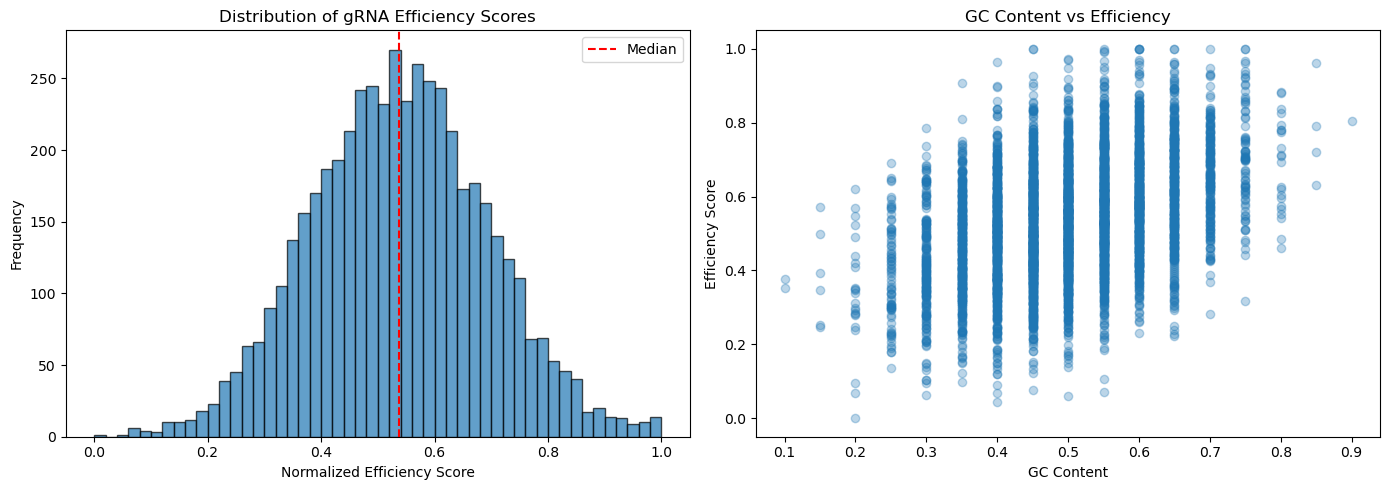

Correlation (GC vs Efficiency): 0.410


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(processed_data['efficiency_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(processed_data['efficiency_score'].median(), color='red', linestyle='--', label='Median')
axes[0].set_xlabel('Normalized Efficiency Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of gRNA Efficiency Scores')
axes[0].legend()

axes[1].scatter(processed_data['gc_content'], processed_data['efficiency_score'], alpha=0.3)
axes[1].set_xlabel('GC Content')
axes[1].set_ylabel('Efficiency Score')
axes[1].set_title('GC Content vs Efficiency')

plt.tight_layout()
plt.show()

print(f"Correlation (GC vs Efficiency): {processed_data['gc_content'].corr(processed_data['efficiency_score']):.3f}")

## 5. Prepare Data for Modeling

In [8]:
X = processed_data.drop('efficiency_score', axis=1)
y = (processed_data['efficiency_score'] > processed_data['efficiency_score'].median()).astype(int)

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Features shape: (5000, 101)
Target distribution: {1: 2500, 0: 2500}

Train set: (4000, 101)
Test set: (1000, 101)


## 6. Feature Selection

In [9]:
selector = SelectKBest(f_classif, k=50)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()].tolist()
print(f"Selected {len(selected_features)} features")
print(f"Top 10 features: {selected_features[:10]}")

Selected 50 features
Top 10 features: ['gc_content', 'pos_0_A', 'pos_0_G', 'pos_0_T', 'pos_1_G', 'pos_3_A', 'pos_3_C', 'pos_3_T', 'pos_4_C', 'pos_5_A']


## 7. Feature Scaling

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("Features scaled")

Features scaled


## 8. Baseline Model Training

In [11]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"{name} ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    results[name] = {
        'model': model,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc
    }


Training Logistic Regression...
Logistic Regression ROC-AUC: 0.6892
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       500
           1       0.64      0.55      0.59       500

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.62      0.62      0.62      1000


Training Random Forest...
Random Forest ROC-AUC: 0.6916
              precision    recall  f1-score   support

           0       0.62      0.71      0.67       500
           1       0.67      0.57      0.61       500

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.64      1000
weighted avg       0.64      0.64      0.64      1000


Training XGBoost...
XGBoost ROC-AUC: 0.6648
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       500
           1       0.63      0.57      0.60       500

    accurac

## 9. ROC Curve Visualization

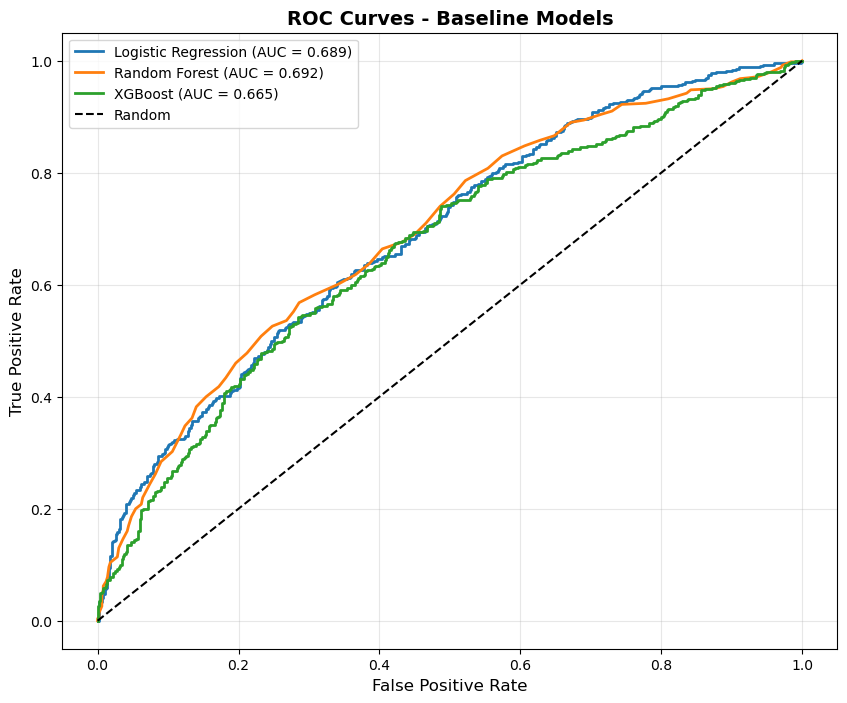

In [12]:
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Baseline Models', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 10. Advanced Feature Engineering

In [13]:
print("Performing correlation analysis...")
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns 
                      if any(upper_triangle[column] > 0.95)]
print(f"Removing {len(high_corr_features)} highly correlated features")

X_decorrelated = X.drop(columns=high_corr_features)
print(f"After correlation filtering: {X_decorrelated.shape}")

Performing correlation analysis...
Removing 0 highly correlated features
After correlation filtering: (5000, 101)


In [14]:
print("Computing mutual information scores...")
mi_scores = mutual_info_classif(X_decorrelated, y, random_state=42)
mi_df = pd.DataFrame({
    'feature': X_decorrelated.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"\nTop 10 features by mutual information:")
print(mi_df.head(10))

top_mi_features = mi_df.head(30)['feature'].tolist()
X_mi_selected = X_decorrelated[top_mi_features]

Computing mutual information scores...

Top 10 features by mutual information:
       feature  mi_score
0   gc_content  0.047276
3      pos_0_G  0.029143
98     C_count  0.028365
97     A_count  0.026176
99     G_count  0.017112
93    kmer2_TA  0.016791
42    pos_10_C  0.015005
23     pos_5_G  0.013439
73    pos_18_A  0.012617
39     pos_9_G  0.011828


In [15]:
print("Creating polynomial features...")
top_10_features = mi_df.head(10)['feature'].tolist()
X_top10 = X_decorrelated[top_10_features]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_top10)
poly_feature_names = poly.get_feature_names_out(top_10_features)

print(f"Polynomial features created: {X_poly.shape[1]}")

X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_mi_selected.index)
X_combined = pd.concat([X_mi_selected, X_poly_df], axis=1)
X_combined = X_combined.loc[:, ~X_combined.columns.duplicated()]

print(f"Combined feature set: {X_combined.shape}")

Creating polynomial features...
Polynomial features created: 55
Combined feature set: (5000, 75)


In [16]:
print("Final feature selection...")
mi_scores_combined = mutual_info_classif(X_combined, y, random_state=42)
mi_indices = np.argsort(mi_scores_combined)[::-1][:50]
X_final = X_combined.iloc[:, mi_indices]

print(f"Final feature set: {X_final.shape}")
print(f"\nTop 10 final features:")
for i, idx in enumerate(mi_indices[:10]):
    print(f"  {X_combined.columns[idx]}: {mi_scores_combined[idx]:.4f}")

Final feature selection...
Final feature set: (5000, 50)

Top 10 final features:
  C_count G_count: 0.0615
  gc_content pos_0_G: 0.0493
  gc_content: 0.0460
  pos_0_G G_count: 0.0439
  gc_content G_count: 0.0404
  gc_content C_count: 0.0399
  pos_0_G A_count: 0.0384
  pos_0_G C_count: 0.0292
  pos_0_G: 0.0289
  T_count: 0.0254


## 11. Advanced Model Training with Grid Search

In [17]:
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

scaler_adv = StandardScaler()
X_train_adv_scaled = scaler_adv.fit_transform(X_train_adv)
X_test_adv_scaled = scaler_adv.transform(X_test_adv)

print(f"Advanced train set: {X_train_adv_scaled.shape}")
print(f"Advanced test set: {X_test_adv_scaled.shape}")

Advanced train set: (4000, 50)
Advanced test set: (1000, 50)


In [28]:
models_and_params = {
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'Support Vector Machine': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 0.01, 0.1]
        }
    },
    'Neural Network': {
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [20, 30],
            'min_samples_split': [2, 5]
        }
    }
}

advanced_results = {}
best_overall_score = 0
best_overall_model = None
best_overall_name = None

for name, config in models_and_params.items():
    print(f"\nGrid Search: {name}")
    print("="*60)
    
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_adv_scaled, y_train_adv)
    
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test_adv_scaled)[:, 1]
    y_pred = best_model.predict(X_test_adv_scaled)
    
    test_score = roc_auc_score(y_test_adv, y_pred_proba)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test ROC-AUC: {test_score:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test_adv, y_pred))
    
    advanced_results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'test_score': test_score,
        'y_pred_proba': y_pred_proba
    }
    
    if test_score > best_overall_score:
        best_overall_score = test_score
        best_overall_model = best_model
        best_overall_name = name


Grid Search: XGBoost
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:31:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:31:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:31:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:31:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not use

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.7228
Test ROC-AUC: 0.6941

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       500
           1       0.65      0.55      0.60       500

    accuracy                           0.62      1000
   macro avg       0.63      0.62      0.62      1000
weighted avg       0.63      0.62      0.62      1000


Grid Search: K-Nearest Neighbors
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best CV score: 0.6734
Test ROC-AUC: 0.6507

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       500
           1       0.62      0.57      0.59       500

    accuracy                           0.61      1000
   macro avg       0.61      0.61      0.61      

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/anaconda3/lib/pyth

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Best CV score: 0.6410
Test ROC-AUC: 0.5838

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       500
           1       0.56      0.53      0.55       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000


Grid Search: Gradient Boosting
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV score: 0.7226
Test ROC-AUC: 0.6949

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.71      0.66       500
           1       0.66      0.55      0.60       500

    accuracy                           0.63      1000
   macro avg     

## 12. Final Results and Comparison

In [29]:
print("="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(f"\nBEST MODEL: {best_overall_name}")
print(f"   Test ROC-AUC: {best_overall_score:.4f}")
print(f"   CV ROC-AUC: {advanced_results[best_overall_name]['cv_score']:.4f}")
print(f"   Best Parameters: {advanced_results[best_overall_name]['best_params']}")

print(f"\nALL MODEL SCORES:")
results_df = pd.DataFrame({
    'Model': list(advanced_results.keys()),
    'CV_Score': [advanced_results[name]['cv_score'] for name in advanced_results.keys()],
    'Test_Score': [advanced_results[name]['test_score'] for name in advanced_results.keys()]
}).sort_values('Test_Score', ascending=False)

print(results_df.to_string(index=False))

FINAL RESULTS SUMMARY

BEST MODEL: Gradient Boosting
   Test ROC-AUC: 0.6949
   CV ROC-AUC: 0.7226
   Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

ALL MODEL SCORES:
                 Model  CV_Score  Test_Score
     Gradient Boosting  0.722610    0.694908
               XGBoost  0.722795    0.694064
Support Vector Machine  0.718280    0.680368
         Random Forest  0.697547    0.661906
   K-Nearest Neighbors  0.673372    0.650670
        Neural Network  0.640979    0.583828


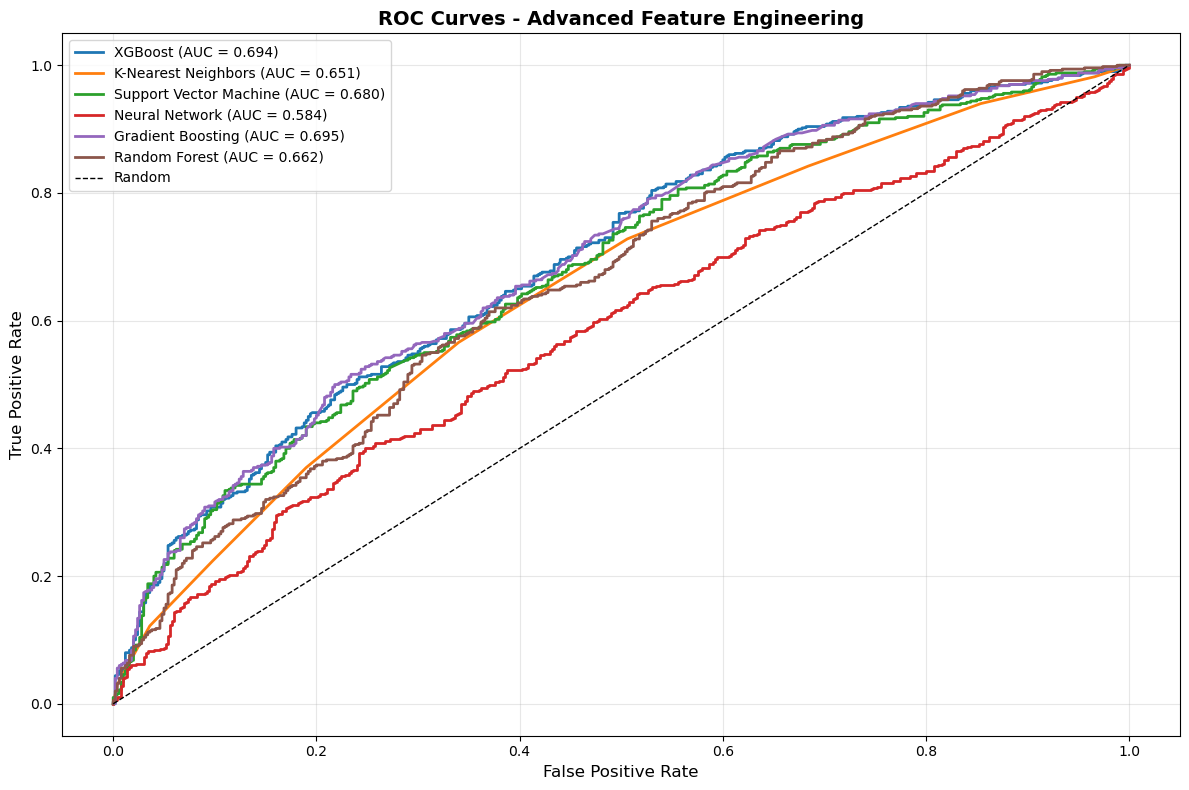

In [30]:
plt.figure(figsize=(12, 8))

for name, result in advanced_results.items():
    fpr, tpr, _ = roc_curve(y_test_adv, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['test_score']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Advanced Feature Engineering', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Model Comparison

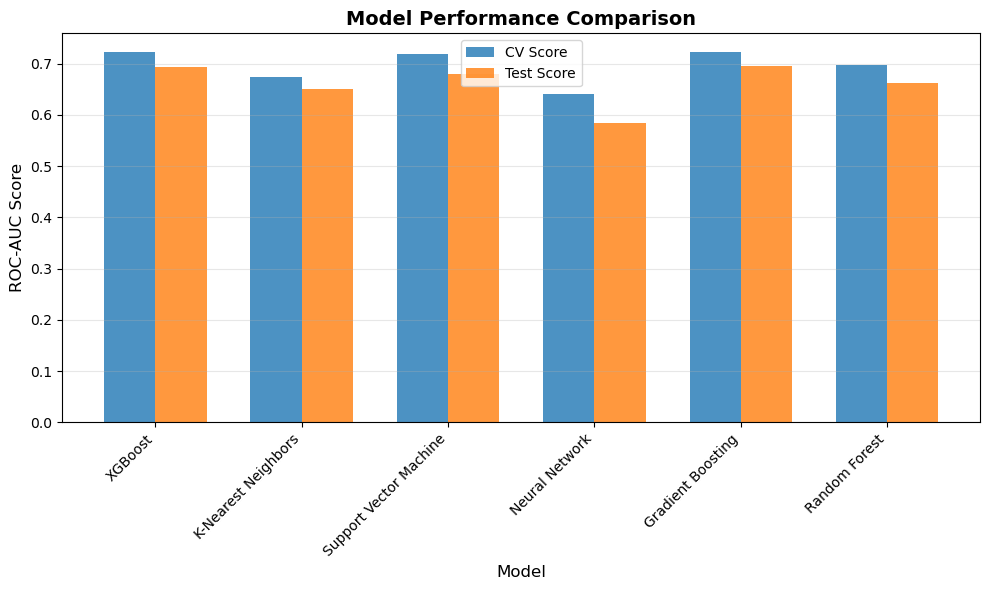

In [31]:
model_names = list(advanced_results.keys())
cv_scores = [advanced_results[name]['cv_score'] for name in model_names]
test_scores = [advanced_results[name]['test_score'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, cv_scores, width, label='CV Score', alpha=0.8)
ax.bar(x + width/2, test_scores, width, label='Test Score', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('ROC-AUC Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Save Models

In [32]:
joblib.dump(best_overall_model, 'models/best_advanced_model.pkl')
joblib.dump(scaler_adv, 'models/advanced_scaler.pkl')

print(f"Best model ({best_overall_name}) saved successfully")
print(f"Final Test ROC-AUC: {best_overall_score:.4f}")

Best model (Gradient Boosting) saved successfully
Final Test ROC-AUC: 0.6949
